**классификатор текстов**

SnowballStemmer+TfidfVectorizer

_Евгений Борисов <esborisov@sevsu.ru>_

## тексты

In [1]:
import pandas as pd
pd.options.display.precision = 2 
pd.options.display.max_colwidth = 200 

from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))
data.sample(2)

записей: 3196


,text,tag
1040,Курс валют на завтра в вашем смартфоне уже сегодня\n\n4 декабря 2016 в 9:00\n\nPR-служба TUT.BY\n\nПриложение «Финансы TUT.BY» радует белорусских пользователей усовершенствованными функциями. В сч...,economics
218,"Ростропович разорвал контракт с Большим театром Премьера\nоперы Прокофьева ""Война и мир"" на новой сцене Большого театра, назначенная\nна 6 декабря, под угрозой срыва...",culture


## токенайзер со стемингом и очисткой

In [5]:
# !pip install natasha 

In [9]:
# import nltk
# nltk.download('stopwords')

In [10]:
# простой токенайзер

import re
from razdel import tokenize
from nltk.corpus import stopwords as nltk_stopwords
stopwords = set(nltk_stopwords.words('russian'))

def tokenizer(text,stopwords=stopwords):
    return [
            t.text for t in tokenize( # разбиваем текст на слова
                re.sub(r'</?[a-z]+>',' ',text), # удаляем xml tag 
            ) 
            if not (
               False
               or (t.text in stopwords) # выкидываем предлоги, союзы и т.п.    
               or re.match(r'^[^a-zA-ZЁёА-я]+$', t.text) # выкидываем токены не содержащие букв
               or re.match(r'^(\w)\1+$', t.text)  # выкидываем токены из одного повторяющегося символа
               or re.match(r'^[^a-zA-ZЁёА-я].*$', t.text)  # выкидываем токены начинающиеся не с буквы
            )
        ] 

In [11]:
# токенайзер cо стеммером
#
# from nltk.tokenize import word_tokenize as nltk_tokenize_word
# from nltk.stem.snowball import SnowballStemmer
# from nltk.corpus import stopwords as nltk_stopwords
# import re

# stemmer = SnowballStemmer('russian')
# stopwords = set(nltk_stopwords.words('russian'))

# def tokenizer(text,stemmer=stemmer,stopwords=stopwords):
#     return [
#             stemmer.stem(t) # выполняем стеминг
#             for t in nltk_tokenize_word( # разбиваем текст на слова
#                 re.sub(r'</?[a-z]+>',' ',text), # удаляем xml tag 
#                 language='russian'
#             ) 
#             if not (
#                (len(t)<3) # выкидываем очень короткие слова
#                or re.match(r'^[^a-zA-ZЁёА-я]+$', t) # выкидываем токены не содержащие букв
#                or re.match(r'^(\w)\1+$', t)  # выкидываем токены из одного повторяющегося символа
#                or re.match(r'^[^a-zA-ZЁёА-я].*$', t)  # выкидываем токены начинающиеся не с буквы
#                or (t in stopwords) # выкидываем предлоги, союзы и т.п.    
#             )
#         ] 
    
# # data['text'].progress_apply(tokenizer)

In [12]:
# # токенайзер с лемматизацией

# from natasha import Doc
# from natasha import Segmenter
# from natasha import MorphVocab
# from natasha import NewsEmbedding
# from natasha import NewsMorphTagger

# from nltk.corpus import stopwords as nltk_stopwords
# stopwords = set(nltk_stopwords.words('russian'))

# seg = Segmenter() # базовый токенизатор
# # морфологический анализ
# tagger = NewsMorphTagger( NewsEmbedding() )
# lvoc = MorphVocab() # лемматизатор

# def tokenizer(text,seg=seg, tagger=tagger, lvoc=lvoc, stopwords=stopwords):
#     doc = Doc(text)
#     doc.segment(seg)
#     doc.tag_morph(tagger)
#     for t in doc.tokens: t.lemmatize(lvoc)
        
#     return [
#         t.lemma for t in doc.tokens
#         if not (
#              False
#             or (t.lemma in stopwords) # выкидываем предлоги, союзы и т.п.  
#             or re.match(r'^[^a-zA-ZЁёА-я]+$', t.lemma) # выкидываем токены не содержащие букв
#             or re.match(r'^(\w)\1+$', t.lemma)  # выкидываем токены из одного повторяющегося символа
#             or re.match(r'^[^a-zA-ZЁёА-я].*$', t.lemma)  # выкидываем токены начинающиеся не с буквы
#         )
#     ]

## выполняем частотный анализ

In [13]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer

# использования токенайзера вместе с векторайзером
tf_model = TfidfVectorizer(
        min_df=.001, # выкидываем очень редкие слова
        max_df=.10, # выкидываем очень частые слова
        use_idf=False, # не используем обратную частоту
        norm='l2', # нормируем TF
        tokenizer=tokenizer, # ф-ция токенайзер
        token_pattern=None, # отключаем дефолтный токенайзер
    )

data_tf = tf_model.fit_transform( data['text'] )

CPU times: user 28.5 s, sys: 26.7 ms, total: 28.6 s
Wall time: 29 s


In [14]:
data_tf.shape

(3196, 19991)

In [15]:
vcb1 = sorted(tf_model.vocabulary_)
print(len(vcb1))
pd.Series(vcb1).sample(30)

19991


7168               кросби
12517      поспособствует
12345           пополнили
16600               спада
7219           кто-нибудь
16108              снимут
5533            зрителями
12021           покрытием
6344              картину
15945              службе
3436              готовым
3110         генерального
3217                  гмк
16162           собранные
4064               длится
1586             броснану
12721             поэтому
8577              награды
338               peugeot
13673    продемонстрирует
14280     разбирательства
7784                маска
12951         предприятие
15205                ряду
17836             тренеры
6875          конфискацию
8503               мюзикл
1678           бюрократия
1924                 весу
19832           ювелирные
dtype: object

## формируем датасеты

In [16]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [17]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( data_tf, y, test_size=0.3, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2237, 19991), (2237,), (959, 19991), (959,))

## обучаем классификатор

In [19]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19).fit(X_train,y_train)

## тестируем

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [21]:
# доля правильных ответов на учебном наборе
o = clf.predict(X_train)
accuracy_score(y_train,o)

0.9991059454626732

In [22]:
# доля правильных ответов на тестовом наборе
o = clf.predict(X_test)

accuracy_score(y_test,o)

0.8696558915537018

In [23]:
print( classification_report( y_test, o, target_names=sorted(labels.keys()) ) )

              precision    recall  f1-score   support

        auto       0.97      0.90      0.93        87
     culture       0.76      0.93      0.84       101
   economics       0.82      0.83      0.82        76
      health       0.83      0.65      0.73        31
    incident       0.90      0.93      0.92       123
    politics       0.87      0.94      0.90       177
      realty       0.93      0.67      0.78        21
     reclama       1.00      0.71      0.83        17
     science       0.88      1.00      0.94        68
      social       0.62      0.36      0.46        44
       sport       0.99      0.98      0.99       118
        tech       0.81      0.74      0.78        89
       woman       0.86      0.86      0.86         7

    accuracy                           0.87       959
   macro avg       0.87      0.81      0.83       959
weighted avg       0.87      0.87      0.86       959



| точность (precision) | полнота (recall) |
| :---: | :---: |
| $\frac{TP}{TP + FP}$ |  $\frac{TP}{TP + FN}$ |
| найдено позитивных / всего найдено |  найдено позитивных / всего позитивных |

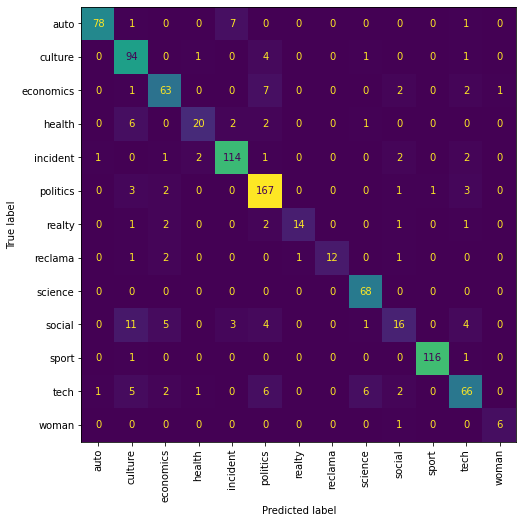

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

fig,ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test,o), 
    display_labels=sorted(labels.keys()),
)
disp.plot(ax=ax, xticks_rotation='vertical', include_values=True, cmap='viridis',  colorbar=False,)
plt.show()

---

In [27]:
data['predict'] = pd.Series( clf.predict(data_tf) ).map( { labels[k]:k for k in labels } )

In [28]:
data

,text,tag,predict
0,"В Саудовской Аравии сняли первый антитеррористический мультфильм -\nтрехминутную ленту ""Внимание!"". ""Внимание!"" отражает точку зрения мирового\nсообщества на войну, развязанную терроризмом, и поэт...",politics,culture
1,"Вчера вечером в Японии состоялась премьера голливудского фильма о гейшах,\nвызвавшая негодование в связи с тем, что эти девушки представлены\nпроститутками, а играющие их актрисы - китаянки. Мало ...",culture,culture
2,"Российский кинорежиссер и генеральный директор киноконцерна ""Мосфильм""\nКарен Шахназаров награжден ""Золотой пирамидой"" на XXIX Каирском кинофестивале\nза выдающийся вклад в мировое киноискусство. ...",culture,culture
3,30 ноября выдающейся российской балерине Майе Плисецкой будет вручена\nмедаль имени княгини Барборы Радвилайте. Церемония награждения состоится\nв Вильнюсе в Литовском национальном театре оперы и ...,culture,culture
4,"Гарольд Пинтер не приедет за Нобелевской премией из-за болезниАнглийский\nдраматург Гарольд Пинтер, получивший Нобелевскую премию по литературе в\n2005 году, отправит в Стокгольм видеозапись своей...",culture,culture
...,...,...,...
3191,Православие.Ру В сентябре 2010 года Святейший Патриарх Кирилл посетит Камчатку\nВопросы подготовки к поездке Предстоятеля Русской Православной Церкви на\nКамчатку обсуждались на встрече Святейшего...,social,social
3192,Интерфакс Религия (interfax-religion.ru) В Минрегионразвития призывают\nроссиян не бояться своего духовного наследия подобно Европе В министерстве\nрегионального развития РФ считают крайне важным ...,social,culture
3193,"Окно возможностей В Эвенкинском муниципальном районе приступили к\nисследованию традиционного уклада жизни. В Эвенкию прибыла экспедиция под\nруководством профессора, заведующего кафедрой менеджме...",science,science
3194,"ИТАР-ТАСС. Новости из властных структур. Совет Федерации предлагает определить\nособенности традиционной охоты коренных народов Севера, Сибири и Дальнего\nВостока Совет Федерации внес на рассмотр...",politics,politics


In [ ]:
# Введение в анализ текстовой информации с помощью Python и методов машинного обучения
# https://habr.com/ru/post/205360/